In [1]:
import numpy
import pandas

from matplotlib import pyplot
%matplotlib inline
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow
import keras
from tensorflow.keras import layers, models, metrics, callbacks

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    print(dirname)
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
ROOT = '/kaggle/input/petfinder-pawpularity-score/'

def read_csv(file):
    return pandas.read_csv(ROOT + file + '.csv', sep=',')

In [3]:
df = read_csv('train')

count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

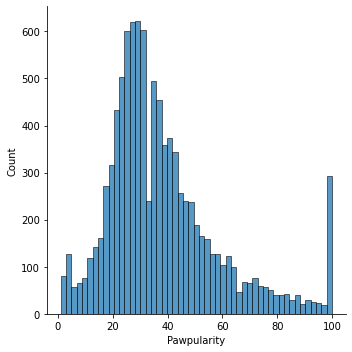

In [4]:
seaborn.displot(df.Pawpularity)

display(df.Pawpularity.describe())

In [5]:
# Later on I will go for something smarter than just mean. ( :
# Let's go with LinearRegression first.
# Return model, pass whole DataFrame
# DataFrame should have the same structure as the train.csv
def linear_regression(df):
    y = df.Pawpularity
    x = df.drop('Pawpularity', axis=1).drop('Id', axis=1)
    train_x, test_x, train_y, test_y = train_test_split(x, y)
    
    model = LinearRegression().fit(train_x, train_y)
    
    res = model.predict(train_x)
    err = numpy.sqrt(mean_squared_error(train_y, res))
    display("Error on train: " + str(err))
    
    res = model.predict(test_x)
    err = numpy.sqrt(mean_squared_error(test_y, res))
    display("Error on test: " + str(err))
    
    return model

In [6]:
def neurons():
    model = models.Sequential()
    n = 32
    i = 128
    
    model.add(layers.Conv2D(n, (3, 3), input_shape=(i, i, 3), padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(n, (3, 3), padding='valid'))
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D())
    n *= 2
    
    model.add(layers.Conv2D(n, (3, 3), padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(n, (3, 3), padding='valid'))
    model.add(layers.Activation('relu'))    
    
    model.add(layers.MaxPooling2D())
    n *= 2
    
    model.add(layers.Conv2D(n, (3, 3), padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(n, (3, 3), padding='valid'))
    model.add(layers.Activation('relu'))    
    
    model.add(layers.MaxPooling2D())
    n *= 2
    
    model.add(layers.Flatten())
    model.add(layers.Dense(n))
    model.add(layers.Activation('relu'))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    model.compile(optimizer='adam', loss='mse', metrics=[metrics.RootMeanSquaredError(name='rmse')])
    return model

stopper = callbacks.EarlyStopping(monitor='val_rmse', patience=40)

In [7]:
imgs = []
y = []
for _, r in df.iterrows():
    imgs.append(tensorflow.image.resize(tensorflow.io.decode_jpeg(tensorflow.io.read_file(ROOT + 'train/' + r['Id'] + '.jpg'), channels=3), [128, 128]))
    y.append(r['Pawpularity'] / 100)

imgs = numpy.array(imgs)
y = numpy.array(y)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [8]:
model = neurons()

model.summary()
model.fit(imgs, y, validation_split=0.2, epochs=20, batch_size=128, callbacks=[stopper])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 64)        0

2021-11-02 18:35:28.173998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
62/62 [==============================] - 252s 4s/step - loss: 0.0606 - rmse: 0.2462 - val_loss: 0.1356 - val_rmse: 0.3682
Epoch 2/20
62/62 [==============================] - 254s 4s/step - loss: 0.0503 - rmse: 0.2242 - val_loss: 0.0605 - val_rmse: 0.2460
Epoch 3/20
62/62 [==============================] - 251s 4s/step - loss: 0.0475 - rmse: 0.2179 - val_loss: 0.0461 - val_rmse: 0.2147
Epoch 4/20
62/62 [==============================] - 251s 4s/step - loss: 0.0476 - rmse: 0.2182 - val_loss: 0.0538 - val_rmse: 0.2319
Epoch 5/20
62/62 [==============================] - 251s 4s/step - loss: 0.0470 - rmse: 0.2169 - val_loss: 0.0454 - val_rmse: 0.2130
Epoch 6/20
62/62 [==============================] - 249s 4s/step - loss: 0.0464 - rmse: 0.2154 - val_loss: 0.0535 - val_rmse: 0.2313
Epoch 7/20
62/62 [==============================] - 249s 4s/step - loss: 0.0457 - rmse: 0.2137 - val_loss: 0.0450 - val_rmse: 0.2121
Epoch 8/20
62/62 [==============================] - 250s 4s/step - lo

In [9]:
#mean = df.Pawpularity.mean()
#display(mean)
#
#model = linear_regression(df)

In [10]:
#test = read_csv('test')

# Easier than droping all the signs.
#res = pandas.DataFrame()
#res['Id'] = test.Id
#test = test.drop('Id', axis=1)
#res['Pawpularity'] = model.predict(test)

#display(res)
#res.to_csv('submission.csv', index=False)

In [11]:
test = read_csv('test')

test_imgs = []
for _, r in test.iterrows():
    test_imgs.append(tensorflow.image.resize(tensorflow.io.decode_jpeg(tensorflow.io.read_file(ROOT + 'test/' + r['Id'] + '.jpg'), channels=3), [128, 128]))

test_imgs = numpy.array(test_imgs)

# Easier than droping all the signs.
res = pandas.DataFrame()
res['Id'] = test.Id
res['Pawpularity'] = model.predict(test_imgs) * 100

display(res.head(10))
res.to_csv('submission.csv', index=False)

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3    35.997494
1  43a2262d7738e3d420d453815151079e    37.132378
2  4e429cead1848a298432a0acad014c9d    38.962467
3  80bc3ccafcc51b66303c2c263aa38486    37.051712
4  8f49844c382931444e68dffbe20228f4    35.085518
5  b03f7041962238a7c9d6537e22f9b017    38.617371
6  c978013571258ed6d4637f6e8cc9d6a3    38.972248
7  e0de453c1bffc20c22b072b34b54e50f    38.081345

In [12]:
#test = read_csv('test')

# Easier than droping all the signs.
#res = pandas.DataFrame()
#res['Id'] = test.Id
#res['Pawpularity'] = mean

#res.to_csv('submission.csv', index=False)